In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_recall_curve, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

In [3]:
acc_dtypes = {
    "place":"category",
    "catu":"category",
    "grav":"category",
    "sexe":"category",
    "trajet":"category",
    "locp":"category",
    "actp":"category",
    "etatp":"category",
    "secuUn":"category",
    "secuDeux":"category",
    "tranches_ages":"category",
    "catr":"category",
    "circ":"category",
    "vosp":"category",
    "prof":"category",
    "plan":"category",
    "surf":"category",
    "infra":"category",
    "situ":"category",
    "senc":"category",
    "obs":"category",
    "obsm":"category",
    "choc":"category",
    "manv":"category",
    "catv_Label":"category",
    "lum":"category",
    "agg":"category",
    "int":"category",
    "atm":"category",
    "col":"category",
    "jour_de_la_semaine":"category",
    "heure":"category",
    "dep": "category"
    }
df = pd.read_csv(r"C:\Users\maill\Documents\GitHub\SARA\data\fusion3.csv", low_memory=False)
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(['Unnamed: 0','num_acc','an_nais','an_naiss','age_acc_an','num_veh','senc','occutc','permis','secuDeux','date','com'], axis=1)
df['place'] = df['place'].astype('object')
df['dep'] = df['dep'].replace({'2A':201,'2B':202})
df['dep'] = df['dep'].astype('int64')

df = df.dropna()

In [9]:
X = df.drop('grav',axis=1)
y = df['grav']

ohe = OneHotEncoder()
categorical_variable = make_column_selector(dtype_exclude=np.number)

X = ohe.fit_transform(X)


X, _, y, _ = train_test_split(X, y, stratify=y, test_size=0.954, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape)

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

print(X_train.shape)

(105420, 481)
(138152, 481)


In [ ]:
# categorical_variable = make_column_selector(dtype_exclude=np.number)
# encoder = make_column_transformer((OneHotEncoder(), categorical_variable))

# model = ImbPipeline(steps=[('transformer', encoder),('undersampling', RandomUnderSampler(random_state=42)),('classifier', RandomForestClassifier(random_state=42))], verbose=True)




# Recherche des meilleurs paramètres
objectifs : reduire l'overfitting et optimiser la performance du modèle grâce au f1_score

In [12]:
# Grille d'hyperparamètres à tester
param_dist = {'n_estimators': [100, 200, 300, 400, 500],
              'learning_rate': [0.01, 0.02, 0.05, 0.1],
              'max_depth': [3, 4, 5, 6, 7],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2', None],
              'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]}


gbc = GradientBoostingClassifier()
n_folds = StratifiedKFold(n_splits=3)
f1_scorer = make_scorer(f1_score, average='macro')

# rechercher dans 100 différentes combinaisons
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = param_dist,
                               n_iter = 100, cv = n_folds, scoring=f1_scorer, verbose=1, random_state=42, n_jobs = -1)
gbc_random.fit(X_train, y_train)

    # Afficher les meilleurs paramètres actuels
print(f"meilleurs paramètres: {gbc_random.best_params_}")
print(f"meilleur score : {gbc_random.best_score_}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
meilleurs paramètres: {'subsample': 0.8, 'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 7, 'learning_rate': 0.1}
meilleur score : 0.7634926694710495


In [14]:
y_pred = gbc_random.best_estimator_.predict(X_test)
print(f"{gbc_random.best_estimator_} \n {X.shape[0]} enregistrements \n avec RandomOverSampler et RandomUnderSampler")
print(pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))
print(classification_report(y_test, y_pred))

GradientBoostingClassifier(max_depth=7, min_samples_leaf=2,
                           min_samples_split=10, n_estimators=400,
                           subsample=0.8) 
 105420 enregistrements 
 avec RandomOverSampler et RandomUnderSampler
Classe prédite      Blessé hospitalisé  Blessé léger  Indemne  Tué
Classe réelle                                                     
Blessé hospitalisé                2178          1095      503  490
Blessé léger                      1606          4188     1627  227
Indemne                            639          1142     6659  158
Tué                                307            57       39  169
                    precision    recall  f1-score   support

Blessé hospitalisé       0.46      0.51      0.48      4266
      Blessé léger       0.65      0.55      0.59      7648
           Indemne       0.75      0.77      0.76      8598
               Tué       0.16      0.30      0.21       572

          accuracy                           0.63     2

# Courbe d'apprentissage

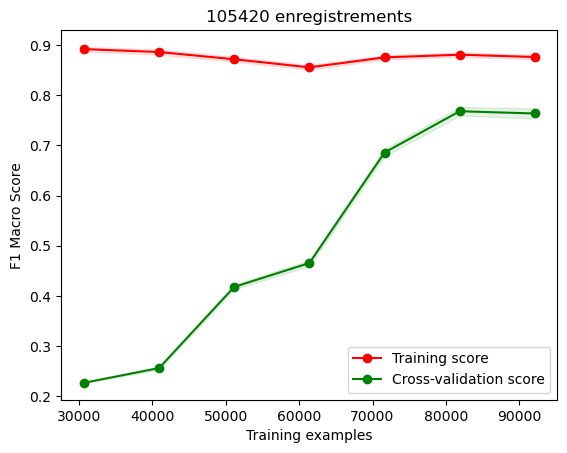

In [13]:
estimator = gbc_random.best_estimator_
train_scores = []
test_scores = []
n_folds = StratifiedKFold(n_splits=3)
f1_scorer = make_scorer(f1_score, average='macro')
# fonction learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=n_folds, scoring=f1_scorer,
                                                        train_sizes=np.linspace(0.0001, 1.0, 10))

# Calculer la moyenne et l'écart type pour les scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer les courbes d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title(f'{X.shape[0]} enregistrements')
plt.xlabel("Training examples")
plt.ylabel("F1 Macro Score")
plt.legend(loc="best")
plt.show()


In [15]:
gbc = GradientBoostingClassifier(subsample= 0.8, n_estimators= 400, min_samples_split= 10, min_samples_leaf= 4, max_features= None, max_depth= 7, learning_rate= 0.1)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print(pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))
print(classification_report(y_test, y_pred))

Classe prédite      Blessé hospitalisé  Blessé léger  Indemne  Tué
Classe réelle                                                     
Blessé hospitalisé                2189          1080      508  489
Blessé léger                      1604          4150     1676  218
Indemne                            630          1126     6689  153
Tué                                294            50       46  182
                    precision    recall  f1-score   support

Blessé hospitalisé       0.46      0.51      0.49      4266
      Blessé léger       0.65      0.54      0.59      7648
           Indemne       0.75      0.78      0.76      8598
               Tué       0.17      0.32      0.23       572

          accuracy                           0.63     21084
         macro avg       0.51      0.54      0.52     21084
      weighted avg       0.64      0.63      0.63     21084



# Precision Recall Curve

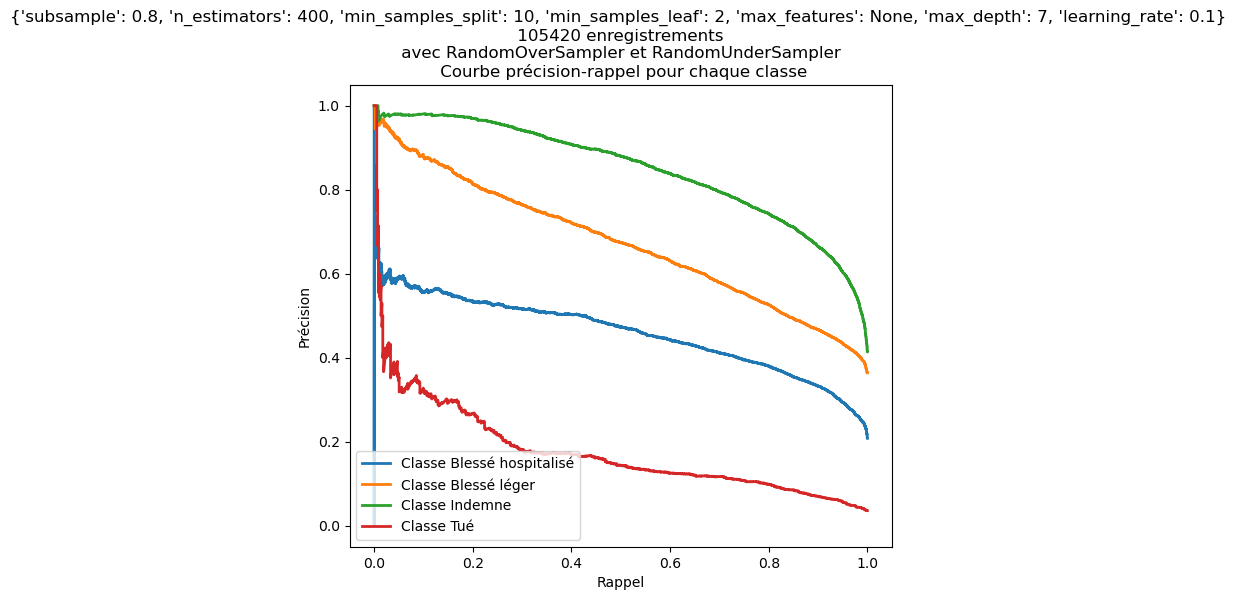

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Initialiser le LabelEncoder
le = LabelEncoder()

# Ajuster le label encoder et transformer les étiquettes de classe en entiers
y_test_encoded = le.fit_transform(y_test)

# Ajuster le modèle et obtenir les probabilités prédites pour l'ensemble de test
y_proba = gbc_random.best_estimator_.predict_proba(X_test)

# Nombre de classes
n_classes = y_proba.shape[1]

# Binariser les étiquettes de classe pour correspondre à `y_proba`
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test_encoded, classes=range(n_classes))

# Calcul de la précision et du rappel pour chaque classe
precision = dict()
recall = dict()
thresholds = dict()

for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_binarized[:, i], y_proba[:, i])

# Tracer les courbes de précision-rappel pour chaque classe
plt.figure(figsize=(7, 6))

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Classe {le.classes_[i]}')

plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title(f"{gbc_random.best_params_} \n {X.shape[0]} enregistrements \n avec RandomOverSampler et RandomUnderSampler \n Courbe précision-rappel pour chaque classe")
plt.legend(loc="best")
plt.show()


# Interprétabilité

In [19]:
pip install shap


     ---------------------------------------- 0.0/23.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/23.2 MB ? eta -:--:--
     --------------------------------------- 0.1/23.2 MB 544.7 kB/s eta 0:00:43
     ---------------------------------------- 0.2/23.2 MB 1.1 MB/s eta 0:00:22
      --------------------------------------- 0.3/23.2 MB 1.7 MB/s eta 0:00:14
     - -------------------------------------- 0.6/23.2 MB 2.7 MB/s eta 0:00:09
     - -------------------------------------- 0.8/23.2 MB 3.0 MB/s eta 0:00:08
     - -------------------------------------- 1.1/23.2 MB 3.5 MB/s eta 0:00:07
     -- ------------------------------------- 1.2/23.2 MB 3.3 MB/s eta 0:00:07
     -- ------------------------------------- 1.3/23.2 MB 3.2 MB/s eta 0:00:07
     -- ------------------------------------- 1.4/23.2 MB 3.1 MB/s eta 0:00:08
     -- ------------------------------------- 1.5/23.2 MB 2.9 MB/s eta 0:00:08
     -- ------------------------------------- 1.6/23.2 MB 3.0 MB/

ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\maill\\AppData\\Local\\Temp\\pip-uninstall-sxx8sdx7\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [21]:
pip install --upgrade numba llvmlite


  Obtaining dependency information for numba from https://files.pythonhosted.org/packages/f8/14/546925a397d7638858a890a01d82cc6de147fca294eccf93ee11b524ca3c/numba-0.58.1-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for llvmlite from https://files.pythonhosted.org/packages/88/99/aa829162a871f0f91dba9a0344726449cafbff4e9e55d7a714051cbb6215/llvmlite-0.41.1-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for numpy<1.27,>=1.22 from https://files.pythonhosted.org/packages/07/34/748ec8c81235277f62cc04488052fe28b8b69280e7275bbb8dc143cd7791/numpy-1.26.2-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     ------------------- ------------------ 30.7/61.2 kB 660.6 kB/s eta 0:00:01
     ------------------------------- ------ 51.2/61.2 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 61.2/61.2 kB 542.2 kB/s e

ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\maill\\anaconda3\\Lib\\site-packages\\~lvmlite\\binding\\llvmlite.dll'
Consider using the `--user` option or check the permissions.



In [22]:
import shap

explainer = shap.Explainer(gbc_random.best_estimator_, X_train)

shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)



ModuleNotFoundError: No module named 'llvmlite.llvmpy'